In [10]:
# STEP 1: Import Required Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, auc, accuracy_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print("✓ Imbalanced-learn library available for handling class imbalance")


✓ All libraries imported successfully
✓ Imbalanced-learn library available for handling class imbalance


In [11]:
# Load the CSV file
path = r"C:\Users\Admin\Desktop\Freelance\Denis\Projects\Retention_Engine\Data\churn.csv"
df = pd.read_csv(path)  

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe())

Dataset shape: (3333, 21)

First few rows:
  State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    KS             128        415  382-4657         no        yes   
1    OH             107        415  371-7191         no        yes   
2    NJ             137        415  358-1921         no         no   
3    OH              84        408  375-9999        yes         no   
4    OK              75        415  330-6626        yes         no   

   VMail Message  Day Mins  Day Calls  Day Charge  ...  Eve Calls  Eve Charge  \
0             25     265.1        110       45.07  ...         99       16.78   
1             26     161.6        123       27.47  ...        103       16.62   
2              0     243.4        114       41.38  ...        110       10.30   
3              0     299.4         71       50.90  ...         88        5.26   
4              0     166.7        113       28.34  ...        122       12.61   

   Night Mins  Night Calls  Night Charge  Intl Mi

In [22]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [12]:
# Create a copy for processing
data = df.copy()

# Drop non-predictive columns
columns_to_drop = ['Phone', 'Area Code']  # These don't add predictive value
data = data.drop(columns=columns_to_drop, errors='ignore')

print(f"\nRemaining features: {data.columns.tolist()}")

# Identify target variable
target_col = 'Churn?'
if target_col not in data.columns:
    # Try alternative names
    churn_cols = [col for col in data.columns if 'churn' in col.lower()]
    if churn_cols:
        target_col = churn_cols[0]
    else:
        print("Warning: Could not find target column. Please specify manually.")

print(f"\nTarget column: {target_col}")
print(f"Churn distribution:\n{data[target_col].value_counts()}")
print(f"Churn rate: {data[target_col].value_counts(normalize=True)}")



Remaining features: ['State', 'Account Length', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Target column: Churn?
Churn distribution:
Churn?
False.    2850
True.      483
Name: count, dtype: int64
Churn rate: Churn?
False.    0.855086
True.     0.144914
Name: proportion, dtype: float64


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [26]:
df['Churn?'] = df['Churn?'].map({False: 0, True: 1})

In [30]:
data['Churn?'].unique()

array(['False.', 'True.'], dtype=object)


Target variable encoded:
0 (No Churn): 0
1 (Churn): 0


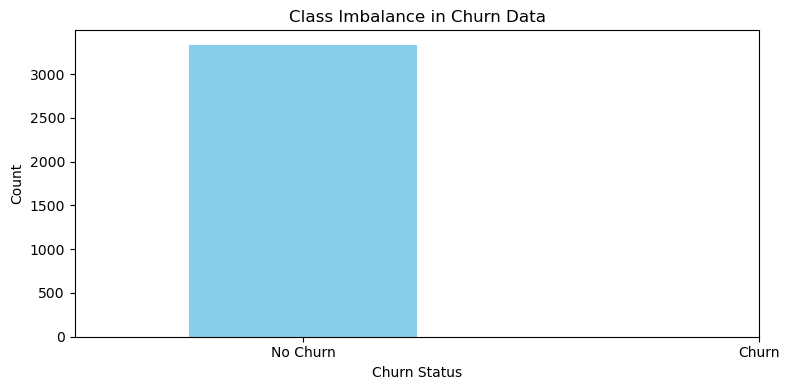

In [31]:
# Separate features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Convert target to binary (0 and 1)
if y.dtype == 'object':
    y = (y.str.lower() == 'true').astype(int)

print(f"\nTarget variable encoded:")
print(f"0 (No Churn): {(y == "False").sum()}")
print(f"1 (Churn): {(y == "True").sum()}")

# Visualize class imbalance
plt.figure(figsize=(8, 4))
y.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Imbalance in Churn Data')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)
plt.tight_layout()
plt.show()


In [14]:
imbalance_ratio = (y == 0).sum() / (y == 1).sum()
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1 (No Churn : Churn)")




Class Imbalance Ratio: inf:1 (No Churn : Churn)


In [15]:
# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")



Categorical columns: ['State', "Int'l Plan", 'VMail Plan']
Numerical columns: ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls']


In [16]:
# Encode categorical variables
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

print(f"\n✓ Categorical variables encoded")



✓ Categorical variables encoded


In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\n✓ Features scaled using StandardScaler")
print(f"Scaled features shape: {X_scaled.shape}")



✓ Features scaled using StandardScaler
Scaled features shape: (3333, 18)


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Training set churn rate: {y_train.mean():.2%}")
print(f"Test set churn rate: {y_test.mean():.2%}")




Train set size: 2666
Test set size: 667
Training set churn rate: 0.00%
Test set churn rate: 0.00%


In [21]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3328    0
3329    0
3330    0
3331    0
3332    0
Name: Churn?, Length: 3333, dtype: int32

In [19]:
print("\n" + "="*50)
print("Handling Class Imbalance")
print("="*50)

print(f"\nBefore resampling:")
print(f"Training set - No Churn: {(y_train == 0).sum()}, Churn: {(y_train == 1).sum()}")

# Use SMOTE for oversampling minority class and undersampling for majority class
smote = SMOTE(random_state=42, k_neighbors=5)
undersampler = RandomUnderSampler(random_state=42)

# Apply SMOTE first, then undersampling
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_resampled, y_train_resampled)

print(f"\nAfter resampling (SMOTE + Undersampling):")
print(f"Training set - No Churn: {(y_train_resampled == 0).sum()}, Churn: {(y_train_resampled == 1).sum()}")
print(f"New class distribution:")
print(y_train_resampled.value_counts())

# Visualize the resampled data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Before Resampling')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)

plt.subplot(1, 2, 2)
y_train_resampled.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('After SMOTE + Undersampling')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)

plt.tight_layout()
plt.show()

print("\n✓ Class imbalance handled successfully")



Handling Class Imbalance

Before resampling:
Training set - No Churn: 2666, Churn: 0


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead

In [ ]:
print("\n" + "="*50)
print("Model Evaluation on Test Set")
print("="*50)

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nAccuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No Churn', 'Churn']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

In [1]:
import shap

c:\Users\Admin\Desktop\Freelance\Denis\Projects\Retention_Engine\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = r"C:\Users\Admin\Desktop\Freelance\Denis\Projects\Retention_Engine\models\xgboost_model.pkl"
explainer = shap.Explainer(path)
shap_values = explainer(X_test)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: C:\Users\Admin\Desktop\Freelance\Denis\Projects\Retention_Engine\models\xgboost_model.pkl